# NLP - Ejercicio Final Integrador

Entrenar un clasificador binario para análisis de sentimiento de sentimiento
utilizando diferentes técnicas de NLP.
1. Descargar el dataset del siguiente [link](https://drive.google.com/file/d/1zX2KM72Enhv8eWyJt1j4x6YZ75XwzHkm/view?usp=sharing).
2. Pre-procesar el texto de manera básica:
  - a. Eliminar tags html: por ejemplo \<br/>
  - b. Eliminar puntuaciones
  - c. Eliminar stopwords
3. Entrenar un clasificador utilizando BOW.
  - a. Definir el tamaño del vocabulario.
  - b. (opcional) Agregar pesos utilizando TFIDF.
  - c. Transformar los textos en vectores.
  - d. Crear los datasets de train, validation y test.
  - e. (opcional) Aplicar PCA para reducir la dimensión de los vectores.
  - f. Entrenar una red neuronal (seleccionar arquitectura, loss y optimizador).
  - g. Medir AUC.
4. Entrenar un clasificador utilizando words embeddings (probar con GloVe y con
FastText).
  - a. Calcular el embedding de cada texto como el promedio de los embeddings
de las palabras.
  - b. Crear los datasets de train, validation y test.
  - c. Entrenar una red neuronal (seleccionar arquitectura, loss y optimizador).
  - d. Medir AUC.
  - e. Tratar de mejorar los embeddings de los textos con:
    - Agregar TFIDF como pesos a las palabras.
    - En lugar de tomar el promedio probar tomando el max o el min de
cada componente de los embeddings de las palabras.
    - Probar diferentes tamaños de embeddings.
5. Entrenar un clasificador utilizando celdas LSTM.
  - a. Convertir secuencias de palabras a secuencias de números (indexer).
  - b. Agregar padding para que cada elemento de entrenamiento tenga la
misma longitud.
  - c. Armar una red LSTM con las siguientes capas:
      - Capa de embedding que transforma un número (index) en un
embedding.
      - Agregar uno dos layers LSTM para obtener el embedding de la
secuencias.
      - Agregar un layer denso para entrenar el clasificador.  

## Desarrollo

In [154]:
# Para futura tabla comparativa (se agregó luego de entrenar y probar todos 
# los modelos, por eso se incorporan manualmanete los resultados)
model_comparison_table = {}

### 1. Descarga y exploración de dataset.

1. Descargar el dataset del siguiente link.

In [3]:
!gdown --id 1zX2KM72Enhv8eWyJt1j4x6YZ75XwzHkm
!unzip "IMDB Dataset.csv.zip"

Downloading...
From: https://drive.google.com/uc?id=1zX2KM72Enhv8eWyJt1j4x6YZ75XwzHkm
To: /content/IMDB Dataset.csv.zip
27.0MB [00:00, 65.1MB/s]
Archive:  IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df[df.isnull().any(axis=1)]

,review,sentiment


In [5]:
df.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [111]:
df['sentiment'].unique()

['positive', 'negative']
Categories (2, object): ['positive', 'negative']

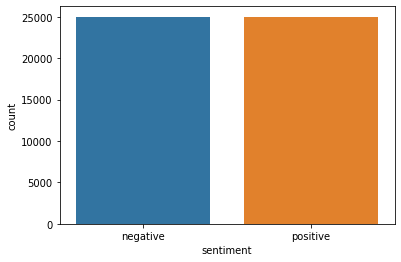

In [112]:
sns.countplot(x='sentiment', data=df)

### 2. Preprocesamiento básico

Pre-procesar el texto de manera básica:
  - a. Eliminar tags html: por ejemplo \<br/>.
  - b. Eliminar puntuaciones.
  - c. Eliminar stopwords.

In [4]:
import nltk
import re

Tags HTML.

In [5]:
tag_re = re.compile(r'<[^>]+>')
df['review'] = df['review'].apply(lambda x: tag_re.sub('',x) )
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Puntuación

In [6]:
df['review'] = df['review'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x ))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there s a family where a little boy ...,negative
4,Petter Mattei s Love in the Time of Money is...,positive


Stop Words

In [7]:
nltk.download('stopwords')
stopwords_re = re.compile(r'\b(' + r'|'.join(nltk.corpus.stopwords.words('english')) + r')\b\s*')
df['review'] = df['review'].apply(lambda x: stopwords_re.sub('',x) )
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment
0,One reviewers mentioned watching Oz episode ho...,positive
1,A wonderful little production The filming tec...,positive
2,I thought wonderful way spend time hot summer ...,positive
3,Basically family little boy Jake thinks zomb...,negative
4,Petter Mattei Love Time Money visually stunni...,positive


Lowercase

In [8]:
df['review'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ho...,positive
1,a wonderful little production the filming tech...,positive
2,i thought wonderful way spend time hot summer ...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter mattei love time money visually stunnin...,positive


Etiquetas.

In [9]:
df["sentiment"] = df["sentiment"].astype('category')
df["target"] = df["sentiment"].cat.codes
df.head()

,review,sentiment,target
0,one reviewers mentioned watching oz episode ho...,positive,1
1,a wonderful little production the filming tech...,positive,1
2,i thought wonderful way spend time hot summer ...,positive,1
3,basically family little boy jake thinks zombie...,negative,0
4,petter mattei love time money visually stunnin...,positive,1


### 3. Clasificador BOW con Red Neuronal

Entrenar un clasificador utilizando BOW.
- a. Definir el tamaño del vocabulario.
- b. (opcional) Agregar pesos utilizando TFIDF.
- c. Transformar los textos en vectores.
- d. Crear los datasets de train, validation y test.
- e. (opcional) Aplicar PCA para reducir la dimensión de los vectores.
- f. Entrenar una red neuronal (seleccionar arquitectura, loss y optimizador).
- g. Medir AUC.

In [12]:
X = df.review
y = df.target

In [156]:
from sklearn.model_selection import train_test_split

TRAIN_TEST_SPLIT = 0.2
TRAIN_VAL_SPLIT = 0.25

X_train_set, X_test, y_train_set, y_test = train_test_split(X, y, test_size=TRAIN_TEST_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(X_train_set,y_train_set,test_size = TRAIN_VAL_SPLIT)

print("Test:",X_test.shape)
print("Train:",X_train.shape)
print("Val:",X_val.shape)

Test: (10000,)
Train: (30000,)
Val: (10000,)


In [157]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

VOCAB_SIZE = 200000
count_vectorizer = CountVectorizer(stop_words="english",max_features=VOCAB_SIZE)

In [158]:
X_train = count_vectorizer.fit_transform(X_train)
X_val = count_vectorizer.transform(X_val)

In [159]:
tfidf_transformer = TfidfTransformer(smooth_idf=False)

X_train = tfidf_transformer.fit_transform(X_train)
X_val = tfidf_transformer.transform(X_val)

In [160]:
N_DIM_REDUC = 512

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(N_DIM_REDUC)

X_train = svd.fit_transform(X_train)
X_val = svd.transform(X_val)

X_train.shape,X_val.shape

((30000, 512), (10000, 512))

In [161]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                25650     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 30,801
Trainable params: 30,801
Non-trainable params: 0
__________________________________________________

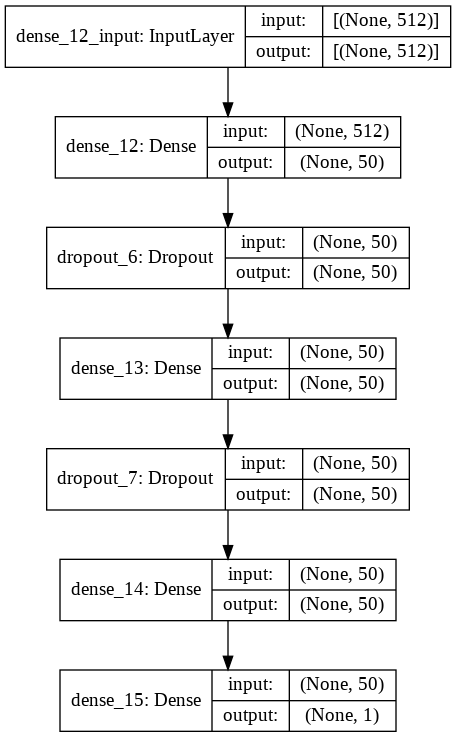

In [162]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils.vis_utils import plot_model


model = Sequential()
model.add(Dense(50, activation = "relu", input_shape=(N_DIM_REDUC, )))
model.add(Dropout(0.3, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(Dense(50, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = [keras.metrics.AUC(name="auc")]
)

NUM_EPOCHS = 5

history = model.fit( X_train, y_train,
            epochs= NUM_EPOCHS,
            batch_size = 32,
            validation_data = (X_val, y_val),
            verbose = True )

Epoch 1/5
938/938 [==============================] - 7s 5ms/step - loss: 0.5964 - auc: 0.7102 - val_loss: 0.3210 - val_auc: 0.9378
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.3231 - auc: 0.9363 - val_loss: 0.3053 - val_auc: 0.9441
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.2839 - auc: 0.9509 - val_loss: 0.2994 - val_auc: 0.9458
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.2537 - auc: 0.9606 - val_loss: 0.2966 - val_auc: 0.9466
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.2393 - auc: 0.9651 - val_loss: 0.2977 - val_auc: 0.9460


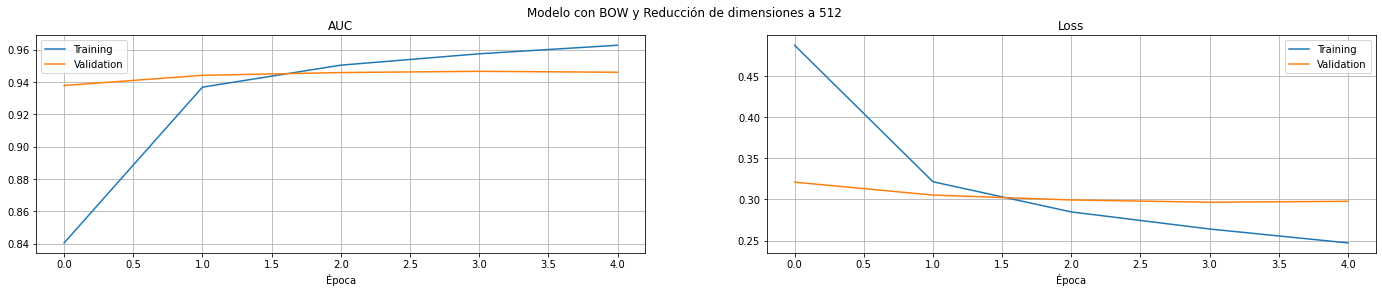

In [24]:
fig,axes = plt.subplots(1,2,figsize=(24,4))
plt.suptitle("Modelo con BOW y Reducción de dimensiones a %d" % N_DIM_REDUC)
axes[0].set_title("AUC")
axes[0].plot(np.arange(NUM_EPOCHS),history.history['auc'])
axes[0].plot(np.arange(NUM_EPOCHS),history.history['val_auc'])
axes[0].legend(["Training","Validation"])
axes[0].grid(which="Both")
axes[0].set_xlabel("Época")
axes[1].set_title("Loss")
axes[1].plot(np.arange(NUM_EPOCHS),history.history['loss'])
axes[1].plot(np.arange(NUM_EPOCHS),history.history['val_loss'])
axes[1].legend(["Training","Validation"])
axes[1].grid(which="Both")
axes[1].set_xlabel("Época")
plt.show()

In [25]:
x_test_tx = count_vectorizer.transform(X_test)
x_test_tx = svd.transform(x_test_tx)
x_test_tx = scaler.transform(x_test_tx)
y_test_pred = model.predict(x_test_tx)

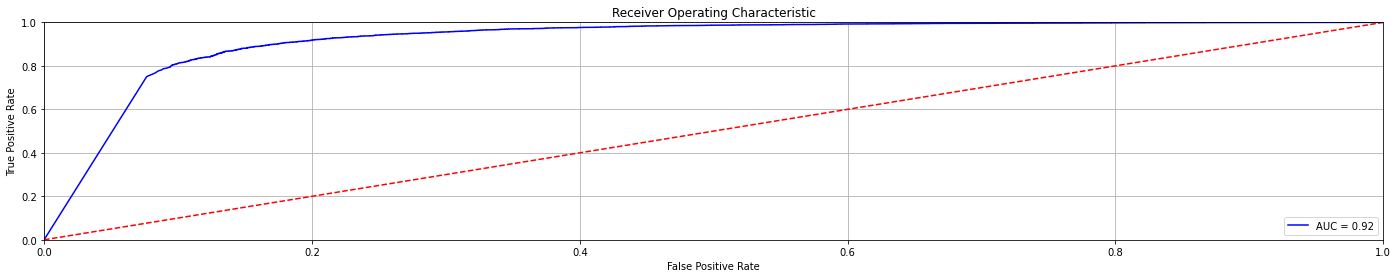

AUC: 0.9213354653418613


In [26]:
import sklearn
from sklearn.metrics import auc

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test.values, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(24,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(which="Both")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:",roc_auc)

In [163]:
model_comparison_table["BOW"] = {
    "AUC": 0.9213354653418613, #roc_auc,
    "Description": "BOW c/ reducción de dimensiones a 512"
}

### 4. Clasificador con Word Embeddings

- Entrenar un clasificador utilizando words embeddings (probar con GloVe y con FastText).
  - a. Calcular el embedding de cada texto como el promedio de los embeddings de las palabras.
  - b. Crear los datasets de train, validation y test.
  - c. Entrenar una red neuronal (seleccionar arquitectura, loss y optimizador).
  - d. Medir AUC.
  - e. Tratar de mejorar los embeddings de los textos con:
    - Agregar TFIDF como pesos a las palabras.
    - En lugar de tomar el promedio probar tomando el max o el min de cada componente de los embeddings de las palabras.
    - Probar diferentes tamaños de embeddings.

Descargar GloVe y FastText.

In [28]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2021-01-01 12:00:59--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2021-01-01 12:00:59--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-01-01 12:00:59--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [114]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip -k cc.en.300.vec.gz

--2021-01-01 22:21:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  50.6MB/s    in 26s     

2021-01-01 22:21:35 (48.6 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



El siguiente código fue copiado del ejemplo de: https://github.com/ejesposito/ceai/blob/master/nlp/word2vec/pretrained.py

In [10]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

logging.basicConfig(level=logging.INFO)

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):

    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):

    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

a. Calcular el embedding de cada texto como el promedio de los embeddings de las palabras.

In [29]:
X = df.review
y = df.target

In [28]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
embedder_model = FasttextEmbeddings()

In [14]:
def embed_corpus_average(corpus,embedder_model):
  X_emb = np.zeros(shape=(len(corpus),embedder_model.N_FEATURES))
  for i in range(len(corpus)):      
      X_emb[i] = np.average( 
          embedder_model.get_words_embeddings( 
              word_tokenize(corpus[i]) 
          ),axis=0)
  return X_emb  

In [15]:
X_emb = embed_corpus_average(X,embedder_model)

In [16]:
X_emb.shape

(50000, 300)

b. Crear los datasets de train, validation y test.

In [33]:
def split_dataset(X,y):
  TRAIN_TEST_SPLIT = 0.2
  TRAIN_VAL_SPLIT = 0.25
  X_train_set, X_test, y_train_set, y_test = train_test_split(X, y, test_size=TRAIN_TEST_SPLIT)
  X_train, X_val, y_train, y_val = train_test_split(X_train_set,y_train_set,test_size = TRAIN_VAL_SPLIT)
  print("Test:",X_test.shape)
  print("Train:",X_train.shape)
  print("Val:",X_val.shape)
  return X_train_set, X_test, y_train_set, y_test,X_train, X_val, y_train, y_val

X_train_set, X_test, y_train_set, y_test,X_train, X_val, y_train, y_val = split_dataset(X_emb,y)

Test: (10000, 300)
Train: (30000, 300)
Val: (10000, 300)


- c. Entrenar una red neuronal (seleccionar arquitectura, loss y optimizador).
- d. Obtener AUC.

In [149]:
import sklearn
from sklearn.metrics import auc

def create_model(n_features):
  model = Sequential()
  model.add(Dense(50, activation = "relu", input_shape=(embedder_model.N_FEATURES, )))
  model.add(Dropout(0.3, noise_shape=None, seed=None))
  model.add(Dense(50, activation = "relu"))
  model.add(Dropout(0.2, noise_shape=None, seed=None))
  model.add(Dense(50, activation = "relu"))
  model.add(Dense(1, activation = "sigmoid"))
  model.summary()
  plot_model(model, show_shapes=True, show_layer_names=True)
  return model

def train_and_evaluate_model(model):
  model_metrics = [
    keras.metrics.AUC(name="auc")
  ]

  # compiling the model
  model.compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = model_metrics
  )

  NUM_EPOCHS = 30

  history = model.fit( X_train, y_train,
              epochs= NUM_EPOCHS,
              batch_size = 32,
              validation_data = (X_val, y_val),
              verbose = True )
  
  fig,axes = plt.subplots(1,2,figsize=(24,4))
  plt.suptitle("Entrenamiento")
  axes[0].set_title("AUC")
  axes[0].plot(np.arange(NUM_EPOCHS),history.history['auc'])
  axes[0].plot(np.arange(NUM_EPOCHS),history.history['val_auc'])
  axes[0].legend(["Training","Validation"])
  axes[0].grid(which="Both")
  axes[0].set_xlabel("Época")
  axes[1].set_title("Loss")
  axes[1].plot(np.arange(NUM_EPOCHS),history.history['loss'])
  axes[1].plot(np.arange(NUM_EPOCHS),history.history['val_loss'])
  axes[1].legend(["Training","Validation"])
  axes[1].grid(which="Both")
  axes[1].set_xlabel("Época")
  plt.show()
  
  y_test_pred = model.predict(X_test)

  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test.values, y_test_pred)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(24,4))
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.grid(which="Both")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  print("AUC:",roc_auc)
  return roc_auc

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                15050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
__________________________________________________

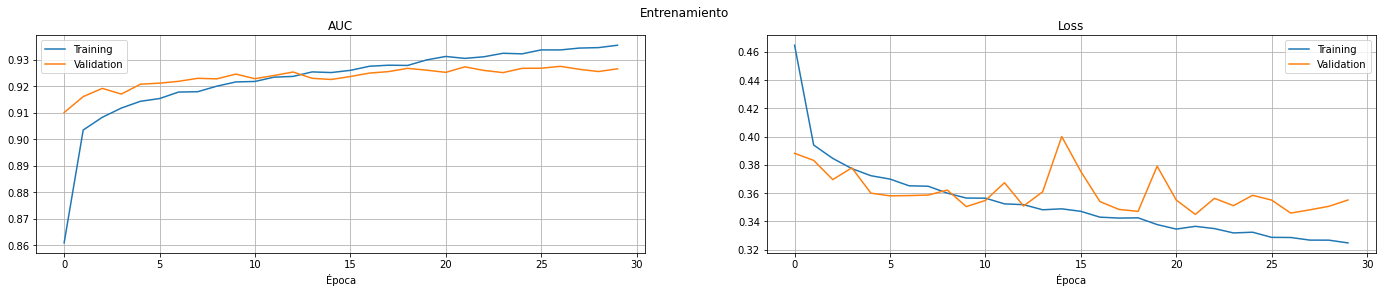

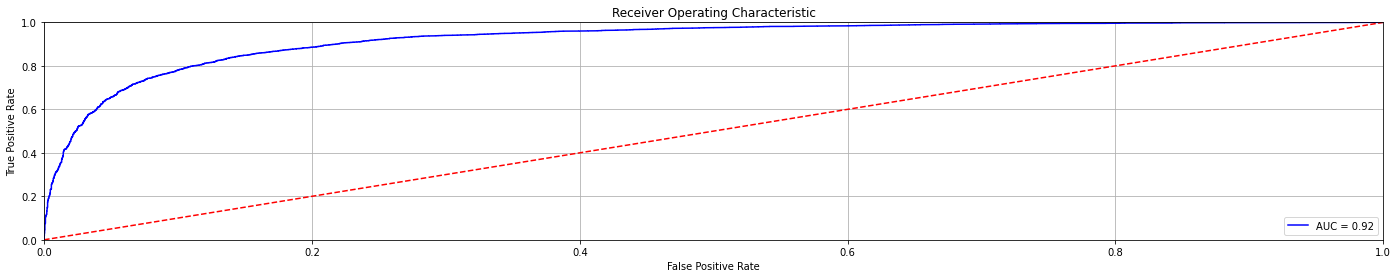

AUC: 0.9237549829902969


In [38]:
model = create_model(n_features=embedder_model.N_FEATURES)
roc_auc = train_and_evaluate_model(model)

In [164]:
model_comparison_table["FastText (Average)"] = {
    "AUC": 0.9237549829902969, #roc_auc,
    "Description": "FastText 300 (cc.en.300.vec.gz)"
}

e. Tratar de mejorar los embeddings de los textos con:
- Agregar TFIDF como pesos a las palabras.


In [135]:
X = df.review.values
y = df.target.values
X_train_set, X_test, y_train_set, y_test,X_train, X_val, y_train, y_val =  split_dataset(X,y)

Test: (10000,)
Train: (30000,)
Val: (10000,)


In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize)

Entrenar el TF-IDF Vectorizer con el Train set y obtener los pesos para el corpus.

In [137]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
feature_names = tfidf_vectorizer.get_feature_names()
inverse_feature_names = { v:k for k, v in enumerate(feature_names)}
len(feature_names)

82157

La siguiente función devuelve los pesos de las palabras de un documento.

In [138]:
def doc_to_weights(doc_idx,doc_matrix, tfidf_doc_matrix):
  """
    doc_idx: índice del documento en ambas matrices
    doc_matrix: matriz con documentos (texto)
    tfidf_doc_matrix: matriz TF-IDF
  """
  tokenized_doc = word_tokenize(doc_matrix[doc_idx])
  indexed_terms = []
  for term in tokenized_doc:
    indexed_terms.append(inverse_feature_names[term] if term in inverse_feature_names else 0)
  doc_weights = [tfidf_doc_matrix[doc_idx].toarray()[:,token_index][0] for token_index in indexed_terms]
  return np.array(doc_weights)

x0_w = doc_to_weights(1,X_train,X_train_tfidf).reshape(-1,1)
x0_w.shape

(43, 1)

In [142]:
def embed_corpus_tfidf_weight(corpus,corpus_tfidf,embedder_model):
  X_emb = np.zeros(shape=(len(corpus),embedder_model.N_FEATURES))
  for i in range(len(corpus)):   
      x_w = doc_to_weights(i,corpus,corpus_tfidf).reshape(-1,1)
      x_e = embedder_model.get_words_embeddings(  word_tokenize(corpus[i]))
      X_emb[i] = np.sum(x_e*x_w,axis=0)/x_w.shape[0]
  return X_emb 

X_train =  embed_corpus_tfidf_weight(X_train,X_train_tfidf,embedder_model)  
X_val =  embed_corpus_tfidf_weight(X_val,X_val_tfidf,embedder_model)  
X_test =  embed_corpus_tfidf_weight(X_test,X_test_tfidf,embedder_model)  

In [151]:
model = create_model(n_features=embedder_model.N_FEATURES)
model.compile(
  optimizer = "adam",
  loss = "binary_crossentropy",
  metrics = [ keras.metrics.AUC(name="auc")]
)

NUM_EPOCHS = 30

history = model.fit( X_train, y_train,
              epochs= NUM_EPOCHS,
              batch_size = 32,
              validation_data = (X_val, y_val),
              verbose = True )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                15050     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 20,201
Trainable params: 20,201
Non-trainable params: 0
__________________________________________________

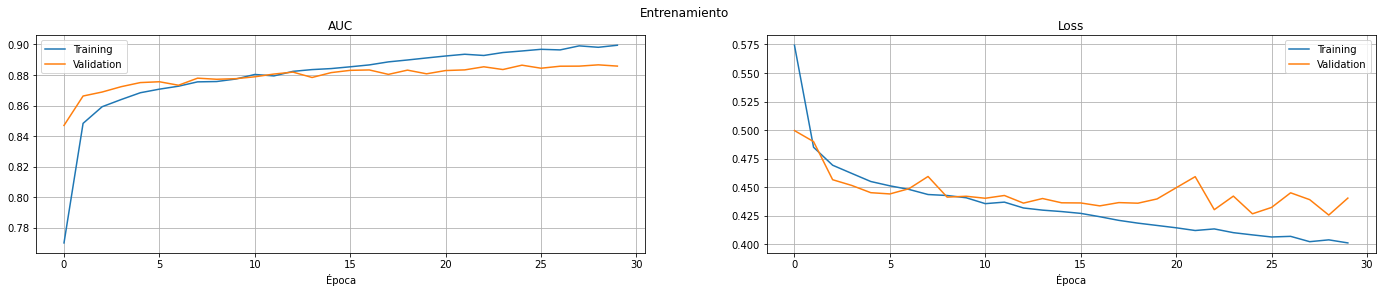

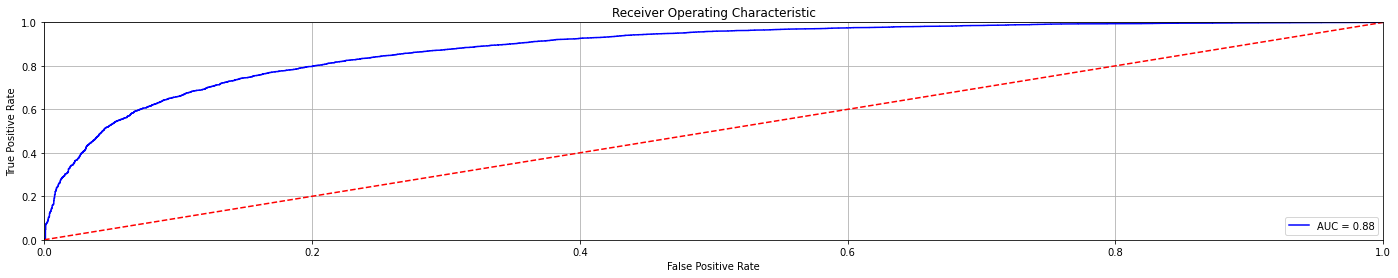

AUC: 0.8834895915067472


In [152]:
fig,axes = plt.subplots(1,2,figsize=(24,4))
plt.suptitle("Entrenamiento")
axes[0].set_title("AUC")
axes[0].plot(np.arange(NUM_EPOCHS),history.history['auc'])
axes[0].plot(np.arange(NUM_EPOCHS),history.history['val_auc'])
axes[0].legend(["Training","Validation"])
axes[0].grid(which="Both")
axes[0].set_xlabel("Época")
axes[1].set_title("Loss")
axes[1].plot(np.arange(NUM_EPOCHS),history.history['loss'])
axes[1].plot(np.arange(NUM_EPOCHS),history.history['val_loss'])
axes[1].legend(["Training","Validation"])
axes[1].grid(which="Both")
axes[1].set_xlabel("Época")
plt.show()

y_test_pred = model.predict(X_test)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(24,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(which="Both")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:",roc_auc)

In [166]:
model_comparison_table["FastText (TF-IDF)"] = {
    "AUC": 0.8834895915067472, # roc_auc,
    "Description": "FastText 300 (cc.en.300.vec.gz)"
}

- En lugar de tomar el promedio probar tomando el max o el min de cada componente de los embeddings de las palabras.

In [43]:
def embed_corpus_max(corpus,embedder_model):
  X_emb = np.zeros(shape=(len(corpus),embedder_model.N_FEATURES))
  for i in range(len(corpus)):      
      X_emb[i] = np.max( 
          embedder_model.get_words_embeddings( 
              word_tokenize(corpus[i]) 
          ),axis=0)
  return X_emb  

def embed_corpus_min(corpus,embedder_model):
  X_emb = np.zeros(shape=(len(corpus),embedder_model.N_FEATURES))
  for i in range(len(corpus)):      
      X_emb[i] = np.min( 
          embedder_model.get_words_embeddings( 
              word_tokenize(corpus[i]) 
          ),axis=0)
  return X_emb  

Test: (10000, 300)
Train: (30000, 300)
Val: (10000, 300)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                15050     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 20,201
Trainable params: 20,201
Non-trainable par

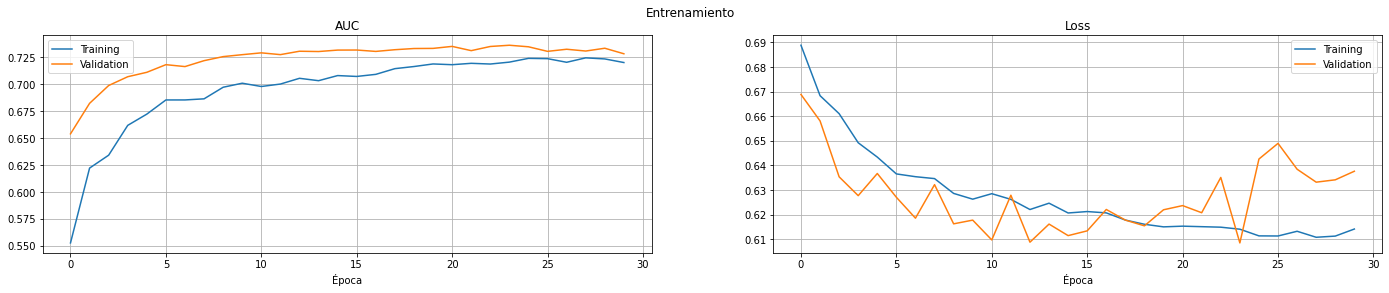

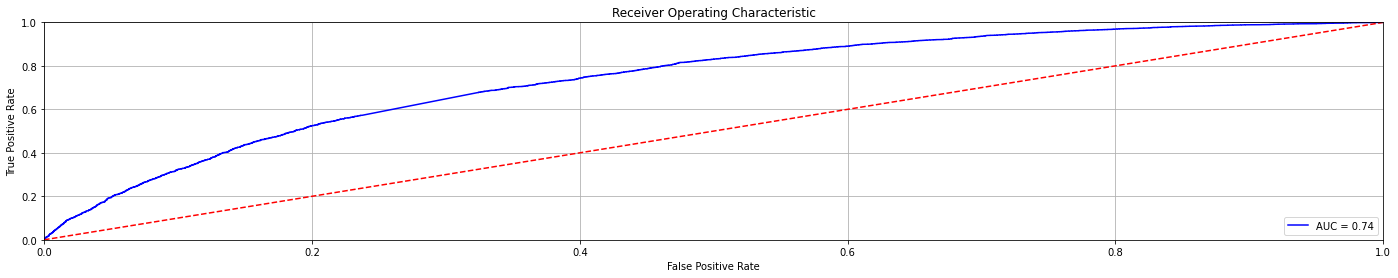

AUC: 0.7392006923537724


In [44]:
X_emb = embed_corpus_max(X,embedder_model)
X_train_set, X_test, y_train_set, y_test,X_train, X_val, y_train, y_val =  split_dataset(X_emb,y)
model = create_model(n_features=embedder_model.N_FEATURES)
roc_auc = train_and_evaluate_model(model)

In [167]:
model_comparison_table["FastText (Max)"] = {
    "AUC": 0.7392006923537724, #roc_auc
    "Description": "FastText 300 (cc.en.300.vec.gz)"
}

Test: (10000, 300)
Train: (30000, 300)
Val: (10000, 300)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                15050     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 20,201
Trainable params: 20,201
Non-trainable par

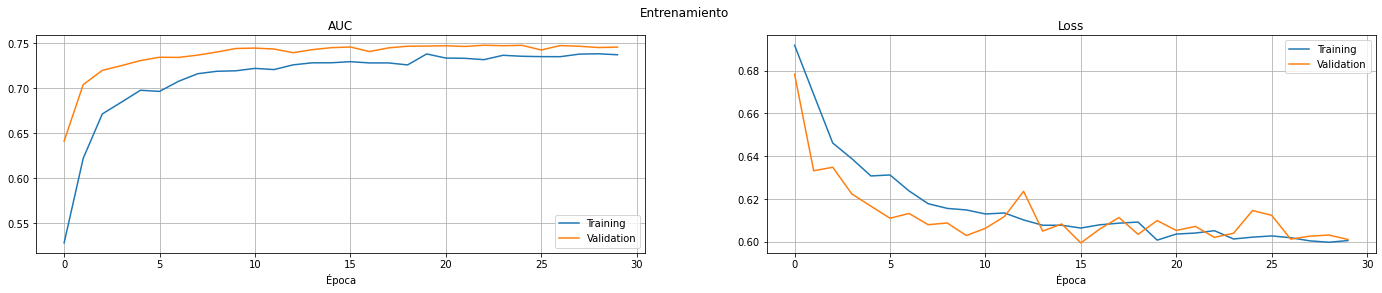

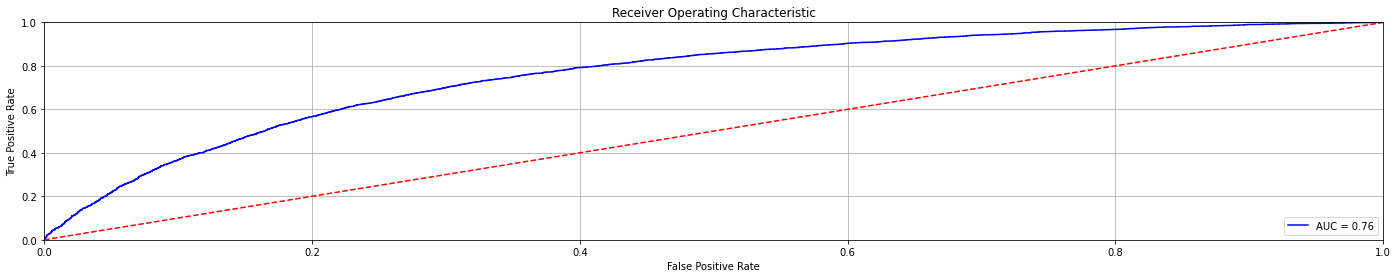

AUC: 0.7621117737390766


In [46]:
X_emb = embed_corpus_min(X,embedder_model)
X_train_set, X_test, y_train_set, y_test,X_train, X_val, y_train, y_val =  split_dataset(X_emb,y)
model = create_model(n_features=embedder_model.N_FEATURES)
roc_auc = train_and_evaluate_model(model)

In [168]:
model_comparison_table["FastText (Min)"] = {
    "AUC": 0.7621117737390766, #roc_auc,
    "Description": "FastText 300 (cc.en.300.vec.gz)"
}

- Probar diferentes tamaños de embeddings.

Test: (10000, 50)
Train: (30000, 50)
Val: (10000, 50)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 7,701
Trainable params: 7,701
Non-trainable params: 

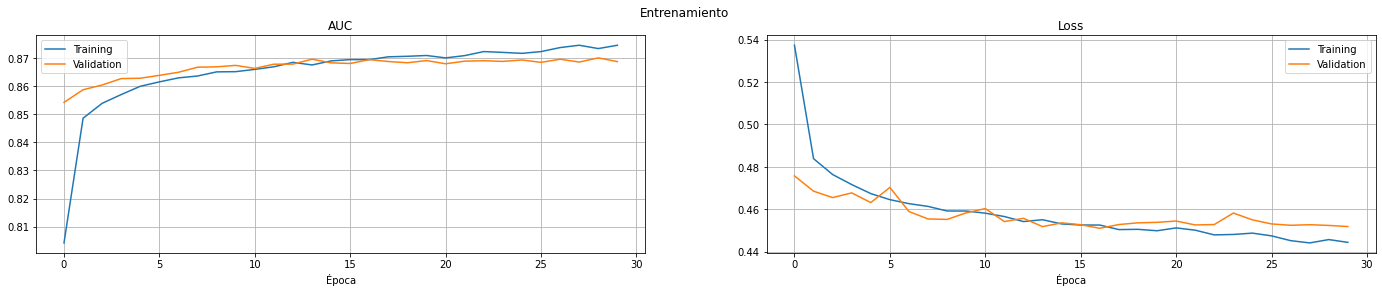

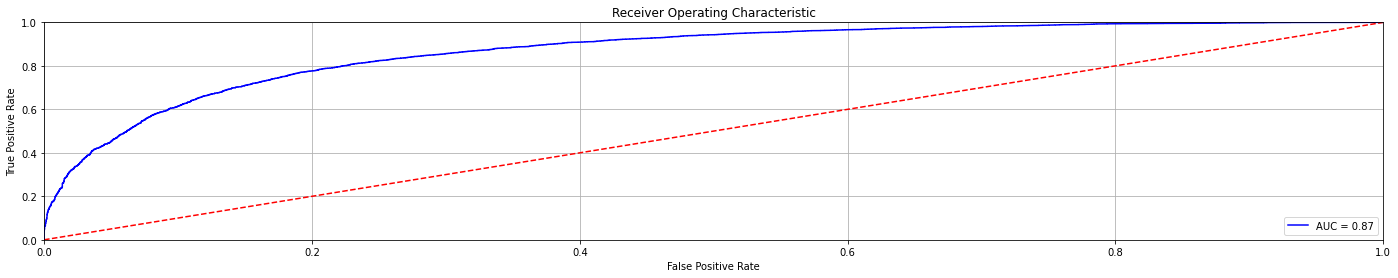

AUC: 0.8682643656506908


In [48]:
embedder_model = GloveEmbeddings()
X_emb = embed_corpus_average(X,embedder_model)
X_train_set, X_test, y_train_set, y_test,X_train, X_val, y_train, y_val =  split_dataset(X_emb,y)
model = create_model(n_features=embedder_model.N_FEATURES)
roc_auc = train_and_evaluate_model(model)

In [169]:
model_comparison_table["GloVE"] = {
    "AUC": 0.8682643656506908, #roc_auc,
    "Description": "GloVE 50 (glove.twitter.27B.zip)"
}

### 5. Clasificador con LSTM

Entrenar un clasificador utilizando celdas LSTM.
- a. Convertir secuencias de palabras a secuencias de números (indexer).
- b. Agregar padding para que cada elemento de entrenamiento tenga la misma longitud.
- c. Armar una red LSTM con las siguientes capas:
  - Capa de embedding que transforma un número (index) en un embedding.
  - Agregar uno dos layers LSTM para obtener el embedding de la secuencias.
  - Agregar un layer denso para entrenar el clasificador.

In [50]:
X = df.review
y = df.target

In [51]:
from sklearn.model_selection import train_test_split

TRAIN_TEST_SPLIT = 0.2
TRAIN_VAL_SPLIT = 0.25

X_train_set, X_test, y_train_set, y_test = train_test_split(X, y, test_size=TRAIN_TEST_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(X_train_set,y_train_set,test_size = TRAIN_VAL_SPLIT)

print("Test:",X_test.shape)
print("Train:",X_train.shape)
print("Val:",X_val.shape)

Test: (10000,)
Train: (30000,)
Val: (10000,)


In [52]:
NUM_WORDS = 20000
EMBEDDING_DIM = 300
SEQ_LENGTH = 200
PADDING_TYPE='post'
TRUNC_TYPE='post'

In [53]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)

In [54]:
X_train_seq = tokenizer.texts_to_sequences(X_train.values)
len(X_train_seq)

30000

In [55]:
X_val_seq = tokenizer.texts_to_sequences(X_val.values)
len(X_val_seq)

10000

In [56]:
X_train_padded = pad_sequences(X_train_seq,maxlen=SEQ_LENGTH,padding=PADDING_TYPE, truncating=TRUNC_TYPE)
X_train_padded[0]

array([    2,  1457,    45,    20,  1849,  8669,   108,    19,    20,
         975,    20,  1133,  1596,    20, 14595,    20,  2817,   107,
         432,  3899, 12386,   103,   730,  1894,  2921,  1023,  1495,
        4065,  2870,  4213,  2165, 10568,  3617,  3175,    55,    13,
         571,   370,  2234,    45,   690,  1067,  9428,  4647,    55,
          13,  2294,  1270,     1,     6,    14,  1397,  1825,  2119,
        1379,   190,  5526,  1379,  1849,  3110,  8669,   306,   519,
         255,  5031,   367,  1468,    64,    89,  1240,   838,     6,
        1002,  3155,  1044,  2772,   109,   679, 11510,  1497,  6063,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [57]:
X_val_padded = pad_sequences(X_val_seq,maxlen=SEQ_LENGTH,padding=PADDING_TYPE, truncating=TRUNC_TYPE)
X_val_padded[0]

array([    1,   237,  5663,  5361,   292,  2382,    62,  1394,    35,
          83,     4,   624,   148,    23,    10,  5361,  4153,     4,
        5088,  1085,  1150,     1,    23,   120,    14,   717,  5361,
        4065,  2870,  1676,   772,  6718,  1922,   916,     2,     5,
         158,   409,  3617,   120,  2927, 15458,     1,  8782,  5676,
       10622,  3468,   541,   845,   707,   314,    23,   714,   592,
         739, 16495,   420,  1597,  2709,   135,    34,  7040,   314,
         714,    83,  6040,   138,    38,  4678,  2615,    34,   221,
        1005,   120,  1286,    49,   558,    34,    24,    13,    20,
        1259,  8057,  4866,  4647,  1258, 10622,   115,    30,  4678,
        2988, 16495,  1625,  1686,  2140,  5937,   572,  2688,   297,
         253,    62, 15244,  2775,   615,   100,  3124,   245,  4409,
         253,  2080,   115,   669,   605,  3674,  1205,  1491,  7765,
         236,  2878,  9673,  2937,    32,     2,   174,   132, 16635,
           2,  4678,

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

def create_model(vocab_size,embedding_dim):
  model = Sequential()

  model.add(Embedding(vocab_size,embedding_dim))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(embedding_dim)))
  model.add(Dense(1,activation='sigmoid'))
  return model


model = create_model(NUM_WORDS,EMBEDDING_DIM)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         6000000   
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 601       
Total params: 7,443,001
Trainable params: 7,443,001
Non-trainable params: 0
_________________________________________________________________


In [59]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001, decay=1e-6),
    metrics=[AUC(name="auc")],
)

In [60]:
NUM_EPOCHS = 10
history = model.fit(
    X_train_padded, 
    y_train, 
    epochs=NUM_EPOCHS, 
    validation_data=(X_val_padded, y_val), 
    verbose=True)

Epoch 1/10
938/938 [==============================] - 121s 120ms/step - loss: 0.6030 - auc: 0.7252 - val_loss: 0.4986 - val_auc: 0.8791
Epoch 2/10
938/938 [==============================] - 112s 120ms/step - loss: 0.3128 - auc: 0.9381 - val_loss: 0.3059 - val_auc: 0.9486
Epoch 3/10
938/938 [==============================] - 112s 120ms/step - loss: 0.1767 - auc: 0.9795 - val_loss: 0.3081 - val_auc: 0.9512
Epoch 4/10
938/938 [==============================] - 112s 120ms/step - loss: 0.1043 - auc: 0.9917 - val_loss: 0.3477 - val_auc: 0.9463
Epoch 5/10
938/938 [==============================] - 112s 119ms/step - loss: 0.0632 - auc: 0.9960 - val_loss: 0.3752 - val_auc: 0.9410
Epoch 6/10
938/938 [==============================] - 112s 119ms/step - loss: 0.0357 - auc: 0.9983 - val_loss: 0.4889 - val_auc: 0.9319
Epoch 7/10
938/938 [==============================] - 113s 120ms/step - loss: 0.0272 - auc: 0.9989 - val_loss: 0.5335 - val_auc: 0.9294
Epoch 8/10
938/938 [============================

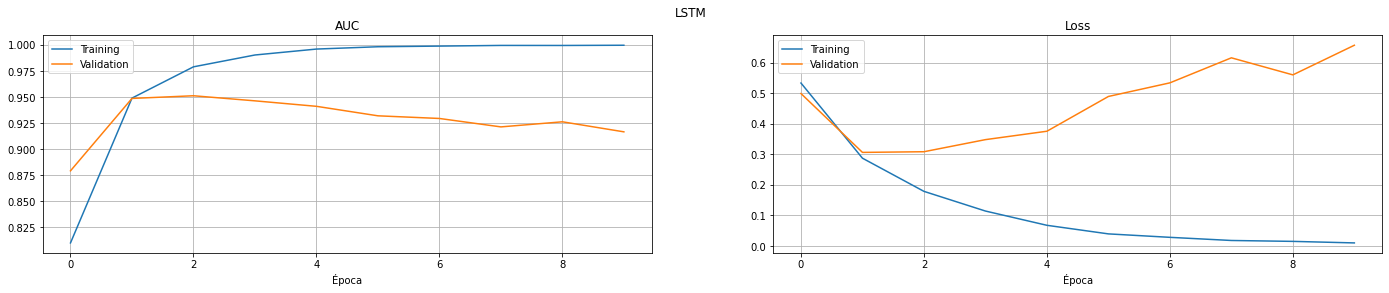

In [64]:
  fig,axes = plt.subplots(1,2,figsize=(24,4))
  plt.suptitle("LSTM")
  axes[0].set_title("AUC")
  axes[0].plot(np.arange(NUM_EPOCHS),history.history['auc'])
  axes[0].plot(np.arange(NUM_EPOCHS),history.history['val_auc'])
  axes[0].legend(["Training","Validation"])
  axes[0].grid(which="Both")
  axes[0].set_xlabel("Época")
  axes[1].set_title("Loss")
  axes[1].plot(np.arange(NUM_EPOCHS),history.history['loss'])
  axes[1].plot(np.arange(NUM_EPOCHS),history.history['val_loss'])
  axes[1].legend(["Training","Validation"])
  axes[1].grid(which="Both")
  axes[1].set_xlabel("Época")
  plt.show()

Se reentrena con una época para obtener el mejor modelo.

In [67]:
NUM_EPOCHS = 1
model = create_model(NUM_WORDS,EMBEDDING_DIM)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001, decay=1e-6),
              metrics=[AUC(name="auc")])
history = model.fit(X_train_padded, y_train, epochs=NUM_EPOCHS, 
                    validation_data=(X_val_padded, y_val), verbose=True)

938/938 [==============================] - 95s 99ms/step - loss: 0.5153 - auc: 0.8053 - val_loss: 0.3503 - val_auc: 0.9310


In [68]:
X_test_seq = tokenizer.texts_to_sequences(X_test.values)
X_test_padded = pad_sequences(X_test_seq,maxlen=SEQ_LENGTH,padding=PADDING_TYPE, truncating=TRUNC_TYPE)
y_test_pred = model.predict(X_test_padded)

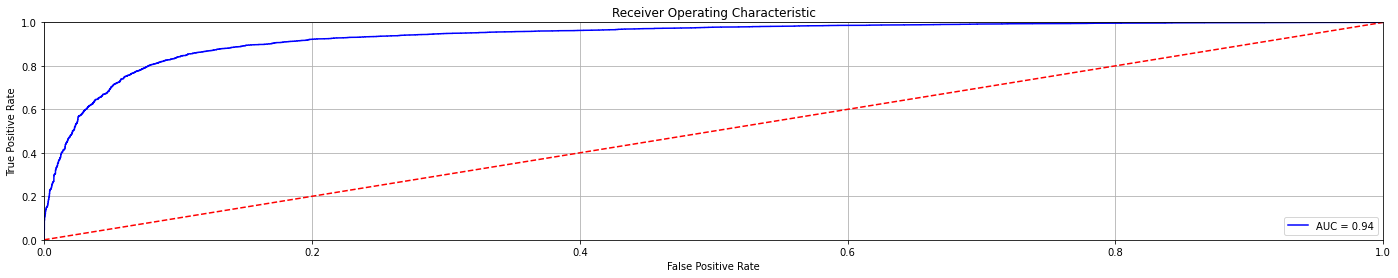

AUC: 0.9353843632321274


In [69]:
import sklearn
from sklearn.metrics import auc

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test.values, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(24,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(which="Both")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:",roc_auc)

In [170]:
model_comparison_table["LSTM"] = {
    "AUC": 0.9353843632321274, # roc_auc,
    "Description": "LSTM c/ Keras Tokenizer"
}

### 6. Clasificador con BERT

Entrenar un clasificador utilizando BERT.
- a.Utilizar BERT sin fine-tuning.
- b.Utilizar BERT con fine-tuning.

Descargar BERT.

In [12]:
!pip install transformers > /dev/null 2>&1

Preparación de dataset para BERT

In [90]:
from sklearn.model_selection import train_test_split
TRAIN_TEST_SPLIT = 0.2
TRAIN_VAL_SPLIT = 0.25

X = df.review.values
y = df.target.values

X_train_set, X_test, y_train_set, y_test = train_test_split(X, y, test_size=TRAIN_TEST_SPLIT)
X_train, X_val, y_train, y_val = train_test_split(X_train_set,y_train_set,test_size = TRAIN_VAL_SPLIT)

In [92]:
MAX_SEQ_LENGTH = 64 

In [91]:
from transformers import BertTokenizer

PRETRAINED_MODEL_NAME = 'bert-base-uncased' 
bert_tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [93]:
def batch_encode(X, tokenizer):
    return tokenizer.batch_encode_plus(
      X,
      max_length=MAX_SEQ_LENGTH,
      add_special_tokens=True, # [CLS] y [SEP] tokens
      return_attention_mask=True,
      return_token_type_ids=False, # no es necesario para clasificador
      pad_to_max_length=True, 
      return_tensors='tf'
    )

In [94]:
X_train_bert = batch_encode(X_train,bert_tokenizer)
X_val_bert = batch_encode(X_val,bert_tokenizer)
X_test_bert = batch_encode(X_test,bert_tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#### BERT sin fine-tuning

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica TFSequenceClassifier 109483778   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 1)            3           tf_bert_for_sequence_class

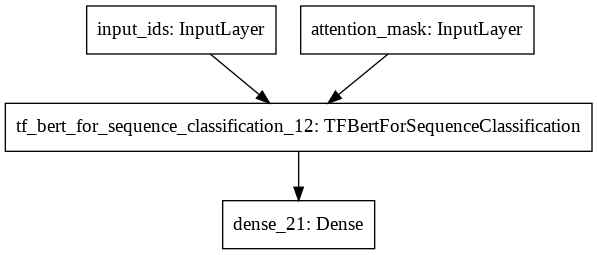

In [95]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from transformers import TFBertForSequenceClassification

def create_bert_model_no_ft():
  bert_model = TFBertForSequenceClassification.from_pretrained(
      PRETRAINED_MODEL_NAME, num_labels=2)
  # Inputs:

  # Layer de input con cadenas de token Ids
  input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_ids')

  # Attention Mask. Máscara binaria para saber a qué tokens prestar atención y a cuáles no.
  attention_mask = tf.keras.layers.Input((MAX_SEQ_LENGTH,), dtype=tf.int32, name='attention_mask')

  # Conectar salidas anteriores con entradas de BERT:
  output = bert_model([input_ids, attention_mask])[0]

  # Clasificación binaria
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

  model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
      loss='binary_crossentropy', 
      metrics=[AUC(name="auc")]
  )    
  return model

model = create_bert_model_no_ft()
model.summary()
tf.keras.utils.plot_model( model )

Entrenamiento BERT sin Fine Tuning.

Como los modelos con BERT tardan mucho en entrenar en Google Colab, se agregan los siguientes callbacks para detener el entrenamiento y obtener el mejor modelo cuando empieza a ocurrir overfitting.


In [96]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
model_fit_callbacks = [
  EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min'),
  #ModelCheckpoint('bert_nofinetuning.hdf5', save_best_only=True, monitor='val_loss', mode='min'),
  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')
]

Lamentablemente ModelCheckpoint genera un error cuando se llama a save_model. TFBertForSequenceClassification no tiene implementado get_config()?.

Para reducir los tiempos de entrenamiento y poder aumentar la cantidad de épocas se trabajará con una partición de train/val reducida.

In [21]:
REDUX_SPLIT = 0.4
TRAIN_REDUX_SIZE = int(X_train.shape[0]*REDUX_SPLIT)
VAL_REDUX_SIZE = int(X_val.shape[0]*REDUX_SPLIT)
TRAIN_REDUX_SIZE, VAL_REDUX_SIZE

(12000, 4000)

In [22]:
train_redux_idx = np.random.choice(np.arange(0,X_train.shape[0]),size=TRAIN_REDUX_SIZE,replace=False)
X_train_redux, y_train_redux = X_train[train_redux_idx],y_train[train_redux_idx]

val_redux_idx = np.random.choice(np.arange(0,X_val.shape[0]),size=VAL_REDUX_SIZE,replace=False)
X_val_redux,y_val_redux = X_val[val_redux_idx],y_val[val_redux_idx]

X_train_redux_bert = batch_encode(X_train_redux,bert_tokenizer)
X_val_redux_bert = batch_encode(X_val_redux,bert_tokenizer)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [83]:
BATCH_SIZE=16
NUM_EPOCHS=10

model = create_bert_model_no_ft()
history = model.fit(
    x=X_train_redux_bert.values(),
    y=y_train_redux,
    validation_data=(X_val_redux_bert.values(), y_val_redux),
    callbacks=model_fit_callbacks,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Epoch 1/10


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


750/750 [==============================] - ETA: 0s - loss: 0.5682 - auc: 0.7370

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


750/750 [==============================] - 193s 245ms/step - loss: 0.5681 - auc: 0.7372 - val_loss: 0.3650 - val_auc: 0.9222
Epoch 2/10
750/750 [==============================] - 193s 258ms/step - loss: 0.2686 - auc: 0.9554 - val_loss: 0.3693 - val_auc: 0.9218
Epoch 3/10
750/750 [==============================] - 196s 261ms/step - loss: 0.1350 - auc: 0.9876 - val_loss: 0.4766 - val_auc: 0.9183

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.
Epoch 4/10
750/750 [==============================] - 197s 262ms/step - loss: 0.0482 - auc: 0.9977 - val_loss: 0.6218 - val_auc: 0.9077
Epoch 5/10
750/750 [==============================] - 197s 262ms/step - loss: 0.0181 - auc: 0.9991 - val_loss: 0.7113 - val_auc: 0.9006

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.9999998787388907e-07.


In [ ]:
NUM_EPOCHS_TRAINED = len(history.history["auc"])
fig,axes = plt.subplots(1,2,figsize=(24,4))
plt.suptitle("BERT con Fine Tuning")
axes[0].set_title("AUC")
axes[0].plot(np.arange(NUM_EPOCHS_TRAINED),history.history['auc'])
axes[0].plot(np.arange(NUM_EPOCHS_TRAINED),history.history['val_auc'])
axes[0].legend(["Training","Validation"])
axes[0].grid(which="Both")
axes[0].set_xlabel("Época")
axes[1].set_title("Loss")
axes[1].plot(np.arange(NUM_EPOCHS_TRAINED),history.history['loss'])
axes[1].plot(np.arange(NUM_EPOCHS_TRAINED),history.history['val_loss'])
axes[1].legend(["Training","Validation"])
axes[1].grid(which="Both")
axes[1].set_xlabel("Época")
plt.show()

Se reentrena con una época porque se vé que no hay una mejora luego.
Esta vez se usa el dataset completo.

In [97]:
NUM_EPOCHS = 1
BATCH_SIZE=16
model = create_bert_model_no_ft()
history = model.fit(
    #x=X_train_redux_bert.values(),
    #y=y_train_redux,
    x=X_train_bert.values(),
    y=y_train,
    validation_data=(X_val_bert.values(), y_val),
    #validation_data=(X_val_redux_bert.values(), y_val_redux),
    #callbacks=model_fit_callbacks,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will a

1875/1875 [==============================] - ETA: 0s - loss: 0.4464 - auc: 0.8646

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1875/1875 [==============================] - 469s 245ms/step - loss: 0.4464 - auc: 0.8646 - val_loss: 0.3573 - val_auc: 0.9335


In [98]:
y_test_pred = model.predict([X_test_bert.input_ids,X_test_bert.attention_mask])

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


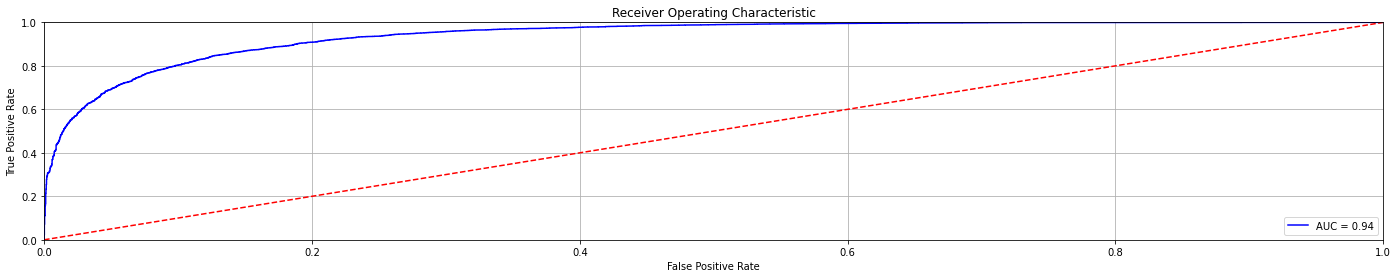

AUC: 0.93906602808635


In [99]:
import sklearn
from sklearn.metrics import auc

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(24,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(which="Both")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:",roc_auc)

In [171]:
model_comparison_table["BERT-NoFT"] = {
    "AUC": 0.93906602808635, #roc_auc, #0.9257985149861581, # roc_auc,
    "Description": "BERT sin Fine Tuning"
}

#### BERT con fine-tuning

Ahora se entrenará la misma arquitectura del caso anterior pero con una capa agrega de Dropout y una capa densa.

In [103]:
def create_bert_model_ft():
  bert_model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME,
                                                             num_labels=2)
  # Inputs:

  # Layer de input con cadenas de token Ids
  input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype=tf.int32, name='input_ids')

  # Attention Mask. Máscara binaria para saber a qué tokens prestar atención y a cuáles no.
  attention_mask = tf.keras.layers.Input((MAX_SEQ_LENGTH,), dtype=tf.int32, name='attention_mask')

  # Conectar salidas anteriores con entradas de BERT:
  output = bert_model([input_ids, attention_mask])[0]

  # Capas custom
  output = tf.keras.layers.Dropout(rate=0.15)(output)
  output = tf.keras.layers.Dense(64)(output)

  # Clasificación binaria
  output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

  model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
      loss='binary_crossentropy', 
      metrics=[AUC(name="auc")]
  )    
  return model

In [31]:
model = create_bert_model_ft()
model.summary()
tf.keras.utils.plot_model( model )

BATCH_SIZE=16
NUM_EPOCHS=10

history = model.fit(
    x=X_train_redux_bert.values(),
    y=y_train_redux,
    validation_data=(X_val_redux_bert.values(), y_val_redux),
    callbacks=model_fit_callbacks,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica TFSequenceClassifier 109483778   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_115 (Dropout)           (None, 2)            0           tf_bert_for_sequence_classi

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/10


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


750/750 [==============================] - ETA: 0s - loss: 0.5619 - auc: 0.7585

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


750/750 [==============================] - 185s 235ms/step - loss: 0.5618 - auc: 0.7587 - val_loss: 0.3943 - val_auc: 0.9209
Epoch 2/10
750/750 [==============================] - 180s 240ms/step - loss: 0.3153 - auc: 0.9395 - val_loss: 0.3700 - val_auc: 0.9249
Epoch 3/10
750/750 [==============================] - 181s 241ms/step - loss: 0.1737 - auc: 0.9802 - val_loss: 0.4499 - val_auc: 0.9136
Epoch 4/10
750/750 [==============================] - 182s 243ms/step - loss: 0.1116 - auc: 0.9903 - val_loss: 0.5572 - val_auc: 0.9047

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.
Epoch 5/10
750/750 [==============================] - 183s 244ms/step - loss: 0.0595 - auc: 0.9969 - val_loss: 0.6908 - val_auc: 0.8954
Epoch 6/10
750/750 [==============================] - 183s 243ms/step - loss: 0.0443 - auc: 0.9974 - val_loss: 0.7605 - val_auc: 0.8904

Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.9999998787388907e-07.


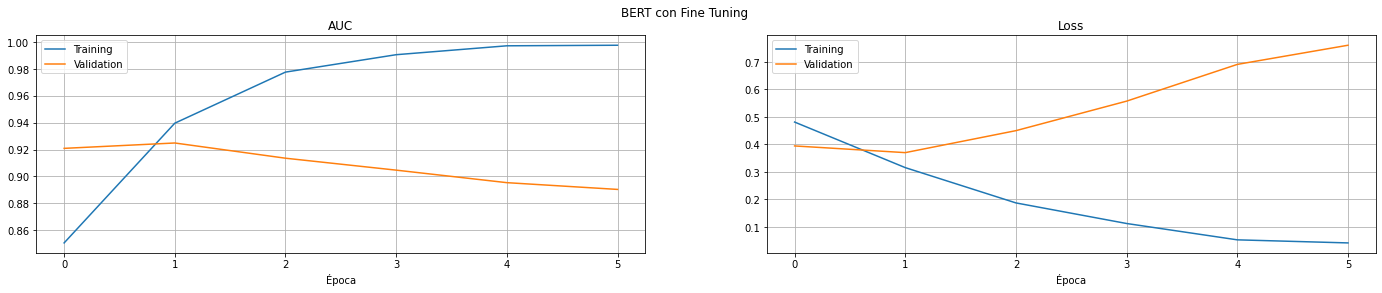

In [38]:
NUM_EPOCHS_TRAINED = len(history.history["auc"])
fig,axes = plt.subplots(1,2,figsize=(24,4))
plt.suptitle("BERT con Fine Tuning")
axes[0].set_title("AUC")
axes[0].plot(np.arange(NUM_EPOCHS_TRAINED),history.history['auc'])
axes[0].plot(np.arange(NUM_EPOCHS_TRAINED),history.history['val_auc'])
axes[0].legend(["Training","Validation"])
axes[0].grid(which="Both")
axes[0].set_xlabel("Época")
axes[1].set_title("Loss")
axes[1].plot(np.arange(NUM_EPOCHS_TRAINED),history.history['loss'])
axes[1].plot(np.arange(NUM_EPOCHS_TRAINED),history.history['val_loss'])
axes[1].legend(["Training","Validation"])
axes[1].grid(which="Both")
axes[1].set_xlabel("Época")
plt.show()

In [104]:
model = create_bert_model_ft()
BATCH_SIZE=16
NUM_EPOCHS=1
history = model.fit(
    #x=X_train_redux_bert.values(),
    #y=y_train_redux,
    x=X_train_bert.values(),
    y=y_train,
    validation_data=(X_val_bert.values(), y_val),
    #validation_data=(X_val_redux_bert.values(), y_val_redux),
    #callbacks=model_fit_callbacks,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will a

1875/1875 [==============================] - ETA: 0s - loss: 0.4788 - auc: 0.8447

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1875/1875 [==============================] - 469s 245ms/step - loss: 0.4788 - auc: 0.8448 - val_loss: 0.3366 - val_auc: 0.9311


In [105]:
y_test_pred = model.predict([X_test_bert.input_ids,X_test_bert.attention_mask])

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


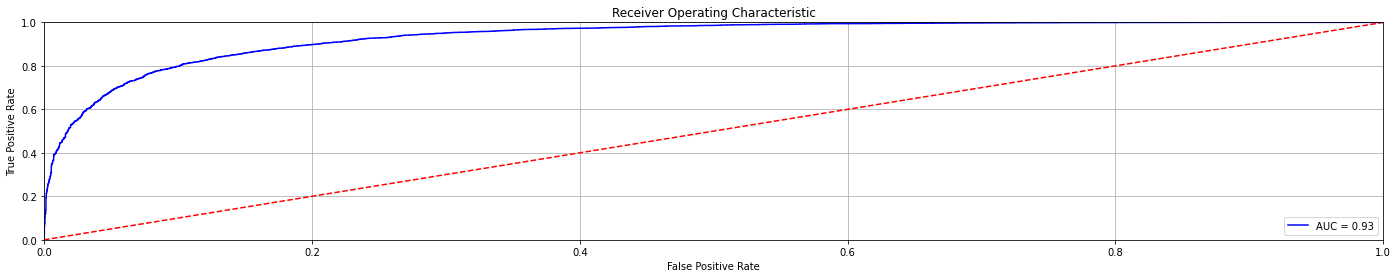

AUC: 0.9345533775808326


In [106]:
import sklearn
from sklearn.metrics import auc

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(24,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid(which="Both")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("AUC:",roc_auc)

In [172]:
model_comparison_table["BERT-FT"] = {
    "AUC": 0.9345533775808326, #roc_auc,
    "Description": "BERT con Fine Tuning"
}

## Conclusiones sobre los métodos de clasificación de textos

Se muestra a continuación una tabla con los resultados de métrica AUC para los modelos ensayados: 


In [173]:
pd.DataFrame.from_dict(model_comparison_table, orient='index').sort_values('AUC',ascending=False)

,AUC,Description
BERT-NoFT,0.939066,BERT sin Fine Tuning
LSTM,0.935384,LSTM c/ Keras Tokenizer
BERT-FT,0.934553,BERT con Fine Tuning
FastText (Average),0.923755,FastText 300 (cc.en.300.vec.gz)
BOW,0.921335,BOW c/ reducción de dimensiones a 512
FastText (TF-IDF),0.883490,FastText 300 (cc.en.300.vec.gz)
GloVE,0.868264,GloVE 50 (glove.twitter.27B.zip)
FastText (Min),0.762112,FastText 300 (cc.en.300.vec.gz)
FastText (Max),0.739201,FastText 300 (cc.en.300.vec.gz)


- Para BERT se obtuvieron los mejores resultados, llegando a AUC=0.97 con HPs que no se registraron (no se pudo repetir este entrenamiento). Se esperaba que BERT mejore con Fine Tuning, por lo que probablemente se pueda hacer algún trabajo adicional en la correcta selección de HPs. Se observa que BERT es sensible a la cantidad de muestras y mostró mejoras cuando se entrenó con el dataset completo (el único inconveniente es el tiempo que toma cada época).
- Es dificil dar con los parámetros correctos para los Embeddings. Se probaron los tamaños por defecto de los modelos de GloVe y FastText pre-entrenados. Si bien se espera que superen a BOW, no siempre fue este el caso.
- La función agrupadora que dá mejor AUC (entre promedio, promedio con TF-IDF, máximo y mínimo) es promedio. 

## Ejercicio 7 (opcional)

Realizar Named Entity Recognition (NER) con alguna de las siguientes opciones:
1. BiLSTM
2. BERT

In [ ]:
# FIXME